<a href="https://colab.research.google.com/github/hargurjeet/Maersk/blob/main/Modelling_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forcasting - Vessel Delays**

The purpose of this task is to give us a gauge of your skills and experience as a data scientist.

The Following notebook is used for building ml model for forcasting expected vessel waiting time at the Post.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Explainatory Data Analysis](#3)
  4. [Feature Engineering](#4)
  5. [Train a baseline model](#5)
  6. [Evaluate Results & Summary](#6)
  7. [Future Work](#7)
  8. [Reference](#8)

# 1: AboutDataset <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

The dataset primiarly conatins the vessel transport information across various geographies. The dataset contains the following features

- 'call_id': ID variable to identify a Vessel at a Port.
- 'arrival_date': arrival date of a vessel at a port.
- 'departure_date': departure date of a vessel at a port.
- 'arrival_time': arrival timestamp of a vessel at a port.
- 'departure_time': departure timestamp of a vessel at a port.
- 'imo': Vessel identifier
- 'vessel_name’: Name of the vessel
- 'vessel_type’: Type of the vessel
- 'Country': Name of the country
- 'CountryCode': Identifier of the Country
- 'Port': Name of The Port
- 'Terminal': Name of the Terminal
- 'Duration': Duration of vessel stay in a Port
- 'Service_name': Name of the service
- 'length': vessel length
- 'vesteu': capacity of a vessel
- 'prev_departure_time': departure time of a vessel from the previous port.
- 'prev_port': Previous port visited by the vessel
- 'prev_arrival_time': arrival time of a vessel at the previous port.
- 'prev_duration': Duration of vessel stay in previous Port
- 'prev_leg_duration': Time taken to travel from previous port to current port
- 'prev_leg_distance_nm': Distance travelled from previous port to current port
- 'prev_leg_stationary_hours': waiting time at the vicinity of Port to get a place to unload the cargo
- 'prev_call_id': ID variable to identify a Vessel at its previous Port.
- 'next_port': Next port visited by the vessel
- 'next_arrival_time': arrival time of a vessel at the next port.
- 'next_duration': Duration of vessel stay in next Port.
- 'next_leg_duration': Time taken to travel from current port to next port
- 'next_leg_distance_nm': Distance travelled from current port to next port
- 'next_leg_stationary_hours': waiting time at the vicinity of next Port to get a place to unload the cargo.
- 'next_call_id': ID variable to identify a Vessel at its next Port.

# 2: Loading the dataset Preprocessing <a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

The dataset has been loaded on my github [repo](https://github.com/hargurjeet/Maersk).

I also import other standard imports to perfrom data analysis, model building...etc

In [1]:
!pip install -q gitpython

In [2]:
# Clone the GitHub repository
repo_url = 'https://github.com/hargurjeet/Maersk'
repo_dir = 'Maersk'
Repo.clone_from(repo_url, repo_dir)

In [3]:
! pip install -r "/content/Maersk/requirments.txt"

In [4]:
## Libraries to import data, preprocessing and building visuals
import pandas as pd
import numpy as np
from git import Repo
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import shap

In [5]:
## Reading the data and parsing the data and time columns
file_path = "/content/Maersk/vessel_data.csv"
date_cols = ['arrival_date', 'departure_date']

dtypes = {
    'imo': 'object',
}

vessel_data = pd.read_csv(file_path, parse_dates=date_cols, dtype=dtypes,)
pd.set_option('display.max_columns', None)
vessel_data.head(2)


,Unnamed: 0,call_id,arrival_date,departure_date,arrival_time,departure_time,imo,vessel_name_ais,vessel_type_ais,Country,CountryCode,Port,Terminal,Duration,Service_name,length,prev_departure_time,vesteu,prev_port,prev_arrival_time,prev_duration,prev_leg_duration,prev_leg_distance_nm,prev_leg_stationary_hours,prev_call_id,next_port,next_arrival_time,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,next_call_id,total_duration_shipment,total_duration_shipment_days,total_distance_shipment
0,0,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,2022-01-05,2022-01-07,2022-01-05 23:00:19+00:00,2022-01-07 21:04:26+00:00,9525376,SAFMARINE CHAMBAL,Container Ship,China,CN,Xiamen,Xiamen Songyu Container Terminal,46.068611,ML - TPX,249.12,2021-12-14 07:00:05+00:00,4496,Haiphong,2021-12-13 17:02:55+00:00,13.952778,544.003889,1598.620103,28,705238686bb73f1947352631d015ad9485d78a9c,Los Angeles,2022-02-10 12:01:14+00:00,207.020556,806.946667,7407.903024,201.0,c77797c9b9822d7a799e6f7664f7d6be5f73f270,1846.992500,76.958021,9006.523126
1,1,c77797c9b9822d7a799e6f7664f7d6be5f73f270,2022-02-10,2022-02-19,2022-02-10 12:01:14+00:00,2022-02-19 03:02:28+00:00,9525376,SAFMARINE CHAMBAL,Container Ship,United States,US,Los Angeles,Apmt Pier 400,207.020556,ML - TPX,249.12,2022-01-07 21:04:26+00:00,4496,Xiamen,2022-01-05 23:00:19+00:00,46.068611,806.946667,7407.903024,201,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,Qingdao,2022-03-08 22:27:41+00:00,105.949167,427.420278,5967.080241,25.0,0dccb61f51069f40de6592464459777a2eb73334,1819.405278,75.808553,13374.983265


In [6]:
# fixing datatypes of columns datatime columns
def remove_timezone_info(data):
    return data.str[:-6]

def convert_to_datetime(data):
    return pd.to_datetime(data, format="%Y-%m-%d %H:%M:%S", errors='coerce')

columns = ['arrival_time', 'departure_time', 'prev_arrival_time', 'prev_departure_time', 'next_arrival_time']

for col in columns:
    vessel_data[col] = remove_timezone_info(vessel_data[col])
    vessel_data[col] = convert_to_datetime(vessel_data[col])


In [7]:
vessel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494042 entries, 0 to 494041
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Unnamed: 0                    494042 non-null  int64         
 1   call_id                       494042 non-null  object        
 2   arrival_date                  494042 non-null  datetime64[ns]
 3   departure_date                494042 non-null  datetime64[ns]
 4   arrival_time                  493604 non-null  datetime64[ns]
 5   departure_time                493614 non-null  datetime64[ns]
 6   imo                           494042 non-null  object        
 7   vessel_name_ais               494042 non-null  object        
 8   vessel_type_ais               494039 non-null  object        
 9   Country                       494042 non-null  object        
 10  CountryCode                   493669 non-null  object        
 11  Port         

## **Observations**

- All the columns datatypes seems to be parsed correctly
- Few columns seems to have null values, but in terms of % nulls there are very minimal.
- Overall dataset size is about half million

In [8]:
vessel_data.head(2)

,Unnamed: 0,call_id,arrival_date,departure_date,arrival_time,departure_time,imo,vessel_name_ais,vessel_type_ais,Country,CountryCode,Port,Terminal,Duration,Service_name,length,prev_departure_time,vesteu,prev_port,prev_arrival_time,prev_duration,prev_leg_duration,prev_leg_distance_nm,prev_leg_stationary_hours,prev_call_id,next_port,next_arrival_time,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,next_call_id,total_duration_shipment,total_duration_shipment_days,total_distance_shipment
0,0,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,2022-01-05,2022-01-07,2022-01-05 23:00:19,2022-01-07 21:04:26,9525376,SAFMARINE CHAMBAL,Container Ship,China,CN,Xiamen,Xiamen Songyu Container Terminal,46.068611,ML - TPX,249.12,2021-12-14 07:00:05,4496,Haiphong,2021-12-13 17:02:55,13.952778,544.003889,1598.620103,28,705238686bb73f1947352631d015ad9485d78a9c,Los Angeles,2022-02-10 12:01:14,207.020556,806.946667,7407.903024,201.0,c77797c9b9822d7a799e6f7664f7d6be5f73f270,1846.992500,76.958021,9006.523126
1,1,c77797c9b9822d7a799e6f7664f7d6be5f73f270,2022-02-10,2022-02-19,2022-02-10 12:01:14,2022-02-19 03:02:28,9525376,SAFMARINE CHAMBAL,Container Ship,United States,US,Los Angeles,Apmt Pier 400,207.020556,ML - TPX,249.12,2022-01-07 21:04:26,4496,Xiamen,2022-01-05 23:00:19,46.068611,806.946667,7407.903024,201,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,Qingdao,2022-03-08 22:27:41,105.949167,427.420278,5967.080241,25.0,0dccb61f51069f40de6592464459777a2eb73334,1819.405278,75.808553,13374.983265


# 3: Explainatory Data Analysis <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

I have performed EDA in a seprate notebook. To access that notebook click [here](https://github.com/hargurjeet/Maersk/blob/main/Solution_Notebook.ipynb)

# 4: Feature Engineering <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

While some features were developed while performing EDA and the same processed dataset is imported in the current notebook. I build some more featues that might add values to the data and help ml models to learn

## 4.1 Building Featuers from data columns

In [9]:
## Splitting data and time
def part_of_dates(df, column):
  """ Extrace Year, Month, day, weekday and hour from a date value """
  df[column+ '_year']= df[column].dt.year
  df[column+ '_month']= df[column].dt.month
  df[column+ '_day']= df[column].dt.day
  df[column+ '_week']= df[column].dt.weekday
  df[column+ '_hour']= df[column].dt.hour

part_of_dates(vessel_data, 'arrival_date')
# part_of_dates(vessel_data, 'departure_date')
# part_of_dates(vessel_data, 'arrival_time')
# part_of_dates(vessel_data, 'departure_time')
part_of_dates(vessel_data, 'prev_departure_time')
# part_of_dates(vessel_data, 'prev_arrival_time')
# part_of_dates(vessel_data, 'next_arrival_time')

In [10]:
vessel_data.head(2)

,Unnamed: 0,call_id,arrival_date,departure_date,arrival_time,departure_time,imo,vessel_name_ais,vessel_type_ais,Country,CountryCode,Port,Terminal,Duration,Service_name,length,prev_departure_time,vesteu,prev_port,prev_arrival_time,prev_duration,prev_leg_duration,prev_leg_distance_nm,prev_leg_stationary_hours,prev_call_id,next_port,next_arrival_time,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,next_call_id,total_duration_shipment,total_duration_shipment_days,total_distance_shipment,arrival_date_year,arrival_date_month,arrival_date_day,arrival_date_week,arrival_date_hour,prev_departure_time_year,prev_departure_time_month,prev_departure_time_day,prev_departure_time_week,prev_departure_time_hour
0,0,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,2022-01-05,2022-01-07,2022-01-05 23:00:19,2022-01-07 21:04:26,9525376,SAFMARINE CHAMBAL,Container Ship,China,CN,Xiamen,Xiamen Songyu Container Terminal,46.068611,ML - TPX,249.12,2021-12-14 07:00:05,4496,Haiphong,2021-12-13 17:02:55,13.952778,544.003889,1598.620103,28,705238686bb73f1947352631d015ad9485d78a9c,Los Angeles,2022-02-10 12:01:14,207.020556,806.946667,7407.903024,201.0,c77797c9b9822d7a799e6f7664f7d6be5f73f270,1846.992500,76.958021,9006.523126,2022,1,5,2,0,2021.0,12.0,14.0,1.0,7.0
1,1,c77797c9b9822d7a799e6f7664f7d6be5f73f270,2022-02-10,2022-02-19,2022-02-10 12:01:14,2022-02-19 03:02:28,9525376,SAFMARINE CHAMBAL,Container Ship,United States,US,Los Angeles,Apmt Pier 400,207.020556,ML - TPX,249.12,2022-01-07 21:04:26,4496,Xiamen,2022-01-05 23:00:19,46.068611,806.946667,7407.903024,201,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,Qingdao,2022-03-08 22:27:41,105.949167,427.420278,5967.080241,25.0,0dccb61f51069f40de6592464459777a2eb73334,1819.405278,75.808553,13374.983265,2022,2,10,3,0,2022.0,1.0,7.0,4.0,21.0


## 4.2 Feature around Vessel duration

In [11]:
## Creating a feature by adding the duration of previous, current and next port to calculate total time take by the shipment.
prev_duration_features = ['prev_duration', 'prev_leg_duration',]
vessel_data['total_pre_duration_vessel'] = vessel_data[prev_duration_features].sum(axis=1)

In [12]:
season_mapping = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
                  7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

# Populate season based on the month
vessel_data['season'] = vessel_data['arrival_date'].dt.month.map(season_mapping)

def categorize_time_of_day_detailed(hour):
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Early Afternoon'
    elif 15 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

vessel_data['time_of_day_detailed'] = vessel_data['arrival_time'].dt.hour.apply(categorize_time_of_day_detailed)

# 5: Train a baseline model <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [13]:
vessel_data.columns

Index(['Unnamed: 0', 'call_id', 'arrival_date', 'departure_date',
       'arrival_time', 'departure_time', 'imo', 'vessel_name_ais',
       'vessel_type_ais', 'Country', 'CountryCode', 'Port', 'Terminal',
       'Duration', 'Service_name', 'length', 'prev_departure_time', 'vesteu',
       'prev_port', 'prev_arrival_time', 'prev_duration', 'prev_leg_duration',
       'prev_leg_distance_nm', 'prev_leg_stationary_hours', 'prev_call_id',
       'next_port', 'next_arrival_time', 'next_duration', 'next_leg_duration',
       'next_leg_distance_nm', 'next_leg_stationary_hours', 'next_call_id',
       'total_duration_shipment', 'total_duration_shipment_days',
       'total_distance_shipment', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day', 'arrival_date_week', 'arrival_date_hour',
       'prev_departure_time_year', 'prev_departure_time_month',
       'prev_departure_time_day', 'prev_departure_time_week',
       'prev_departure_time_hour', 'total_pre_duration_vessel', 'seas

In [14]:
## The function count the uniques values across categorical columns
def calculate_count_and_percentage(data, column_name):
    # Calculate value counts and total count
    value_counts = data[column_name].value_counts()
    total_count = len(data)

    # Calculate percentage values
    percentage_values = (value_counts / total_count) * 100

    # Create a new DataFrame with count and percentage values
    result_df = pd.DataFrame({f'{column_name}_Count': value_counts, f'{column_name}_Percentage': percentage_values})

    return result_df

# Example usage
# Assuming vessel_data is your DataFrame
output_vessel_type = calculate_count_and_percentage(vessel_data, 'vessel_type_ais')
output_Country = calculate_count_and_percentage(vessel_data, 'Country')
output_Port = calculate_count_and_percentage(vessel_data, 'Port')
output_prev_port = calculate_count_and_percentage(vessel_data, 'prev_port')
# output_next_port = calculate_count_and_percentage(vessel_data, 'next_port')

In [15]:
## The function puts the categroies into a general category 'others' expect the top n values
def categorize_top_values(column_name, data, top_n):
    # Get the top n values
    top_values = data[column_name].value_counts().nlargest(top_n).index

    # Create a new column with top values and 'Others'
    data[f'{column_name}_Categorized'] = np.where(data[column_name].isin(top_values), data[column_name], 'Others')


# Example usage
# Assuming vessel_data is your DataFrame
categorize_top_values('vessel_type_ais', vessel_data, 2)
categorize_top_values('Country', vessel_data, 3)
categorize_top_values('Port', vessel_data, 3)
categorize_top_values('prev_port', vessel_data, 3)

In [16]:
vessel_data.columns

Index(['Unnamed: 0', 'call_id', 'arrival_date', 'departure_date',
       'arrival_time', 'departure_time', 'imo', 'vessel_name_ais',
       'vessel_type_ais', 'Country', 'CountryCode', 'Port', 'Terminal',
       'Duration', 'Service_name', 'length', 'prev_departure_time', 'vesteu',
       'prev_port', 'prev_arrival_time', 'prev_duration', 'prev_leg_duration',
       'prev_leg_distance_nm', 'prev_leg_stationary_hours', 'prev_call_id',
       'next_port', 'next_arrival_time', 'next_duration', 'next_leg_duration',
       'next_leg_distance_nm', 'next_leg_stationary_hours', 'next_call_id',
       'total_duration_shipment', 'total_duration_shipment_days',
       'total_distance_shipment', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day', 'arrival_date_week', 'arrival_date_hour',
       'prev_departure_time_year', 'prev_departure_time_month',
       'prev_departure_time_day', 'prev_departure_time_week',
       'prev_departure_time_hour', 'total_pre_duration_vessel', 'seas

In [32]:
## List of columns which are not very relevant and does not contribute to ml training
not_rel = ['Unnamed: 0', 'call_id', 'arrival_date', 'departure_date', 'arrival_time', 'departure_time', \
           'imo', 'vessel_name_ais','vessel_type_ais', 'Country', 'CountryCode', 'Terminal', 'Service_name',\
           'prev_departure_time','prev_port', 'prev_arrival_time',\
          'prev_call_id', 'next_port',  'next_arrival_time', 'next_duration', 'next_leg_duration',\
           'next_leg_distance_nm', 'next_leg_stationary_hours','next_call_id','total_duration_shipment',\
           'total_duration_shipment_days',\
           'Port', 'Duration', 'total_distance_shipment','total_pre_duration_vessel','prev_departure_time_year',
          #  'prev_duration',
          #  'prev_leg_duration','prev_leg_distance_nm',
           'arrival_date_day', 'arrival_date_hour','prev_departure_time_day','prev_departure_time_hour',\
           'arrival_date_week']

target = ['prev_leg_stationary_hours']

In [33]:
# Split data into features and target
X = vessel_data.drop(not_rel + target,axis=1)
y = vessel_data['prev_leg_stationary_hours']

print(X.shape)

(494042, 15)


In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494042 entries, 0 to 494041
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   length                       494042 non-null  float64
 1   vesteu                       494042 non-null  int64  
 2   prev_duration                494038 non-null  float64
 3   prev_leg_duration            494042 non-null  float64
 4   prev_leg_distance_nm         494042 non-null  float64
 5   arrival_date_year            494042 non-null  int32  
 6   arrival_date_month           494042 non-null  int32  
 7   prev_departure_time_month    493582 non-null  float64
 8   prev_departure_time_week     493582 non-null  float64
 9   season                       494042 non-null  object 
 10  time_of_day_detailed         494042 non-null  object 
 11  vessel_type_ais_Categorized  494042 non-null  object 
 12  Country_Categorized          494042 non-null  object 
 13 

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'int32','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [36]:
print("numeric_features", numeric_features)
print("categorical_features", categorical_features)

numeric_features Index(['length', 'vesteu', 'prev_duration', 'prev_leg_duration',
       'prev_leg_distance_nm', 'arrival_date_year', 'arrival_date_month',
       'prev_departure_time_month', 'prev_departure_time_week'],
      dtype='object')
categorical_features Index(['season', 'time_of_day_detailed', 'vessel_type_ais_Categorized',
       'Country_Categorized', 'Port_Categorized', 'prev_port_Categorized'],
      dtype='object')


In [37]:
## Numberic Transformation
# Step 1: Impute missing values in numerical features using median
imputer = SimpleImputer(strategy='median')
X_train_numeric_imputed = imputer.fit_transform(X_train[numeric_features])
X_test_numeric_imputed = imputer.transform(X_test[numeric_features])

# Step 2: Scale the numerical features using StandardScaler
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric_imputed)
X_test_numeric_scaled = scaler.fit_transform(X_test_numeric_imputed)

# Step 3:Creating dataframes
X_train_numeric_df = pd.DataFrame(X_train_numeric_scaled, columns=numeric_features)
X_test_numeric_df = pd.DataFrame(X_test_numeric_scaled, columns=numeric_features)

## Categorical transformation
# Step 1: Impute missing values in categorical features using most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train_categorical_imputed = categorical_imputer.fit_transform(X_train[categorical_features])
X_train_categorical_df_names = pd.DataFrame(X_train_categorical_imputed, columns=categorical_features)

X_test_categorical_imputed = categorical_imputer.transform(X_test[categorical_features])
X_test_categorical_df_names = pd.DataFrame(X_test_categorical_imputed, columns=categorical_features)

# Step 2: One-hot encode the categorical features
onehot_encoder = OneHotEncoder()
X_train_categorical_encoded = onehot_encoder.fit_transform(X_train_categorical_df_names)
X_test_categorical_encoded = onehot_encoder.transform(X_test_categorical_df_names)

# Step 3: Creating dataframe
X_train_categorical_df = pd.DataFrame(X_train_categorical_encoded.toarray(), columns=onehot_encoder.get_feature_names_out())
X_test_categorical_df = pd.DataFrame(X_test_categorical_encoded.toarray(), columns=onehot_encoder.get_feature_names_out())

##Combining data
X_train_combined = pd.concat([X_train_numeric_df, X_train_categorical_df], axis=1)
X_test_combined = pd.concat([X_test_numeric_df, X_test_categorical_df], axis=1)

print(X_train_combined.shape, X_test_combined.shape)

(395233, 35) (98809, 35)


In [29]:
# Randomly select around 24k records from the training set
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_combined, y_train, train_size=24000, random_state=42)

# Randomly select around 6k records from the testing set
_, X_test_subset, _, y_test_subset = train_test_split(X_test_combined, y_test, test_size=6000, random_state=42)

print(X_train_subset.shape, y_train_subset.shape, X_test_subset.shape, y_test_subset.shape)

(24000, 32) (24000,) (6000, 32) (6000,)


In [24]:
%%time
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_subset, y_train_subset)

# Make predictions on the training set
y_pred_subset = rf_regressor.predict(X_test_subset)

# Calculate RMSE and MSE
rmse = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset))
print("RMSE:", rmse)

RMSE: 85.20470667525642
CPU times: user 19.6 s, sys: 255 ms, total: 19.8 s
Wall time: 22.3 s


In [25]:
# Get feature importances from the trained Random Forest Regressor
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
feature_names = X_train_subset.columns  # Assuming X_train is a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                                       Feature  Importance
4                    prev_departure_time_month    0.195440
1                                       vesteu    0.155671
0                                       length    0.155274
3                           arrival_date_month    0.155190
5                     prev_departure_time_week    0.061813
8                                season_Summer    0.026563
7                                season_Spring    0.022384
2                            arrival_date_year    0.021096
17  vessel_type_ais_Categorized_Container Ship    0.017237
13                time_of_day_detailed_Evening    0.017145
14             time_of_day_detailed_Late Night    0.016838
16                  time_of_day_detailed_Night    0.015454
6                                  season_Fall    0.015032
11        time_of_day_detailed_Early Afternoon    0.013604
15                time_of_day_detailed_Morning    0.012663
9                                sea

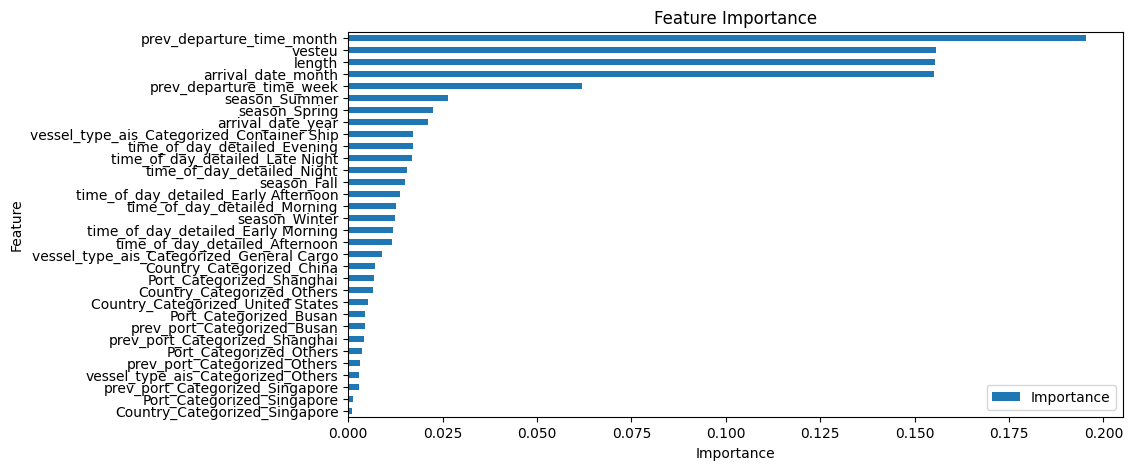

In [26]:
# Plot the feature importance
feature_importance_df.sort_values(by='Importance', ascending=True).plot(x='Feature', y='Importance', kind='barh', figsize=(10, 5))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# not able to execute due to limited computing
# %%time
# ex = shap.Explainer(rf_regressor)
# shap_values = ex.shap_values(X_test_subset)
# shap.summary_plot(shap_values, X_test_subset)

In [45]:
# Randomly select around 24k records from the training set
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_combined, y_train, train_size=20000, random_state=42)

# Randomly select around 6k records from the testing set
_, X_test_subset, _, y_test_subset = train_test_split(X_test_combined, y_test, test_size=5000, random_state=42)

# Instantiate XGBoost Regressor
xgb_regressor = xgb.XGBRegressor()
# Fit the model on the training data
xgb_regressor.fit(X_train_subset, y_train_subset)

# Make predictions on the test data
y_pred_subset = xgb_regressor.predict(X_test_subset)

# Calculate RMSE and MSE scores
rmse = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset))
mse = mean_squared_error(y_test_subset, y_pred_subset)

print("RMSE: ", rmse)

RMSE:  46.830127096008084


In [46]:
# Extract feature importance from the trained XGBRegressor model
feature_importance = xgb_regressor.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
3,prev_leg_duration,0.220737
4,prev_leg_distance_nm,0.079435
13,time_of_day_detailed_Afternoon,0.071749
25,Country_Categorized_Singapore,0.059439
7,prev_departure_time_month,0.057978
32,prev_port_Categorized_Others,0.050058
28,Port_Categorized_Others,0.047909
20,vessel_type_ais_Categorized_Container Ship,0.039065
11,season_Summer,0.038510
1,vesteu,0.032131


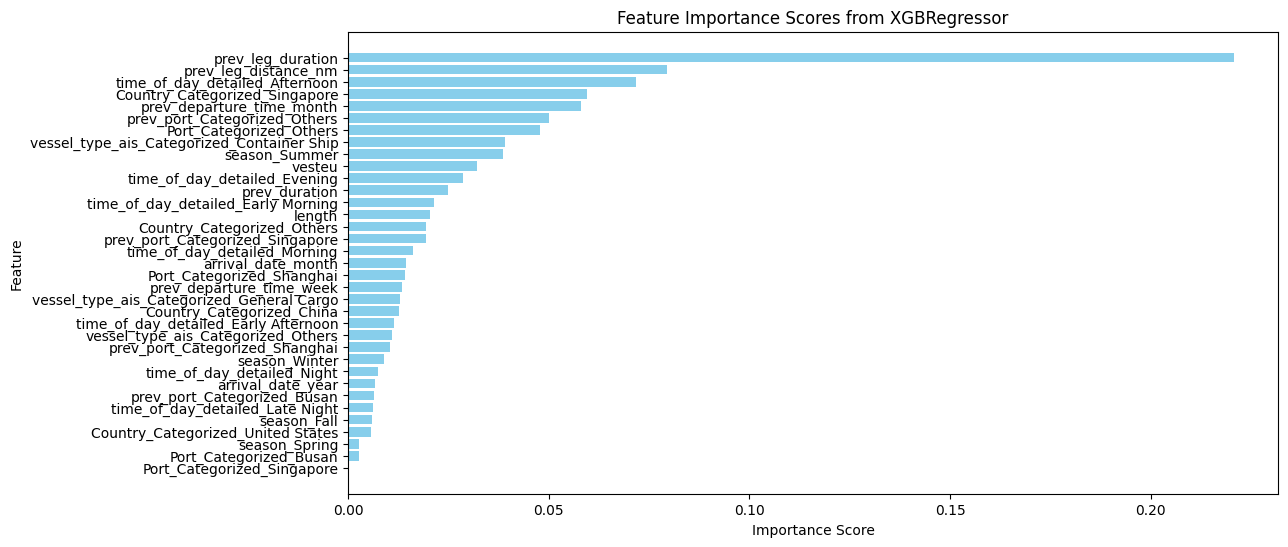

In [40]:
# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Scores from XGBRegressor')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

In [41]:
%%time

# Define the parameter grid to search
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 7),
    'n_estimators': randint(100, 500),
    'subsample': uniform(0.5, 0.3),
    'colsample_bytree': uniform(0.5, 0.3),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 1)
}

# Instantiate the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor()

# Perform grid search with cross-validation
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train_subset, y_train_subset)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Make predictions on the test data using the best estimator
y_pred_subset_tuned = best_estimator.predict(X_test_subset)

# Calculate RMSE and MSE scores
rmse_tuned = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset_tuned))

print("Tuned RMSE: ", rmse_tuned)
print("Best parameters: ", best_params)


Tuned RMSE:  45.75641061485284
Best parameters:  {'colsample_bytree': 0.7722699421778279, 'learning_rate': 0.034929222914887495, 'max_depth': 3, 'n_estimators': 242, 'reg_alpha': 0.37777556927152434, 'reg_lambda': 0.22879816549162246, 'subsample': 0.5230939729486379}
CPU times: user 4min 13s, sys: 1.12 s, total: 4min 14s
Wall time: 3min 10s


In [66]:
X_test_subset.index

Index([ 9709,   585, 29035, 60702, 58159,  7841, 80046, 14401, 92355, 90444,
       ...
       97274, 38030, 98609, 44114, 94852, 47763, 18633, 78773, 10885, 38854],
      dtype='int64', length=20000)

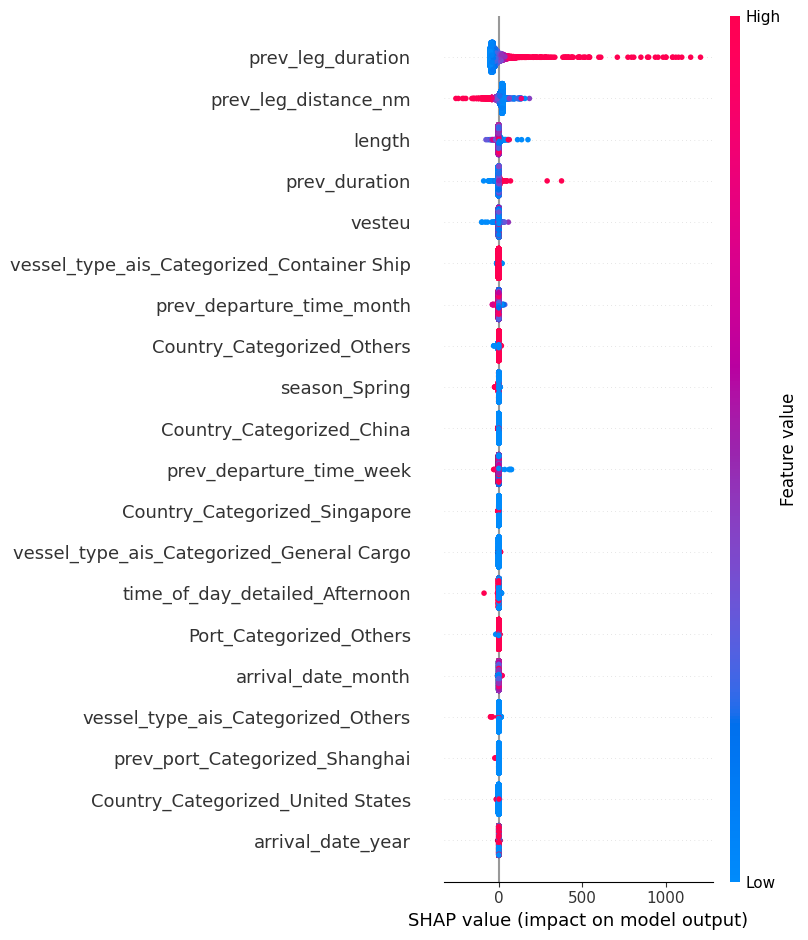

In [47]:
# Use the SHAP library to calculate SHAP values
explainer = shap.Explainer(best_estimator)
shap_values = explainer.shap_values(X_test_subset)

# Plot the summary plot of SHAP values
shap.summary_plot(shap_values, X_test_subset)

In [48]:
chosen_instance = X_test_subset.loc[[60702]]
shap_values = explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], chosen_instance)

In [52]:
chosen_instance = X_test_subset.loc[[7841]]
shap_values = explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], chosen_instance)

In [41]:
X_test_subset.index

Index([ 9709,   585, 29035, 60702, 58159,  7841, 80046, 14401, 92355, 90444,
       ...
       56183, 36162, 36954, 30854, 45762, 87040, 34606, 30414, 72275, 87072],
      dtype='int64', length=5000)

# 6: Results and Summary <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

- After training both classical machine learning models, Random Forest and XGBoost, I found that both models performed well. However, the results from the Random Forest model seemed more intuitive and interpretable.

- The Feature Importance analysis of the Random Forest model revealed that the waiting time of a vessel is notably influenced by the departure time of the vessel from the previous port and the arrival time at the current port. Additionally, the model indicated that vessel length and capacity play significant roles in determining vessel waiting time.

-  the XGBoost model placed less emphasis on the vessel's arrival time at the port. Instead, it learned that features such as pre-duration, pre-leg duration, and pre-stationary hours were the most influential factors in predicting waiting times. This suggests that the XGBoost model focused on different aspects of the data compared to the Random Forest model.


# 7: Future Work <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

- One major piece of information was the port information. Target encoding can be tried out.
- As we have huge volume of data an advanced Neaural network which can learn the long term dependecy of the vessel and the shipments.

# 8: Reference <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

- pandas - https://pandas.pydata.org/docs/
- seaborn - https://seaborn.pydata.org/
- matplotlib - https://matplotlib.org/stable/index.html
- tensorflow - https://www.tensorflow.org/api_docs/python/tf